C:\Users\cuong\AppData\Local\Temp\ipykernel_15088\4139990724.py:196: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('epoch : %d/%d err = %f' % (i+1, epochs, err))


epoch : 1/1000 err = 0.717627
epoch : 2/1000 err = 0.689204
epoch : 3/1000 err = 0.674620
epoch : 4/1000 err = 0.668343
epoch : 5/1000 err = 0.663753
epoch : 6/1000 err = 0.661106
epoch : 7/1000 err = 0.658342
epoch : 8/1000 err = 0.656050
epoch : 9/1000 err = 0.653878
epoch : 10/1000 err = 0.651783
epoch : 11/1000 err = 0.649638
epoch : 12/1000 err = 0.647640
epoch : 13/1000 err = 0.645578
epoch : 14/1000 err = 0.643923
epoch : 15/1000 err = 0.641827
epoch : 16/1000 err = 0.639971
epoch : 17/1000 err = 0.638190
epoch : 18/1000 err = 0.636371
epoch : 19/1000 err = 0.634286
epoch : 20/1000 err = 0.632896
epoch : 21/1000 err = 0.631080
epoch : 22/1000 err = 0.629167
epoch : 23/1000 err = 0.627671
epoch : 24/1000 err = 0.625606
epoch : 25/1000 err = 0.624343
epoch : 26/1000 err = 0.622221
epoch : 27/1000 err = 0.620439
epoch : 28/1000 err = 0.619308
epoch : 29/1000 err = 0.617724
epoch : 30/1000 err = 0.615825
epoch : 31/1000 err = 0.612631
epoch : 32/1000 err = 0.613651
epoch : 33/1000 e

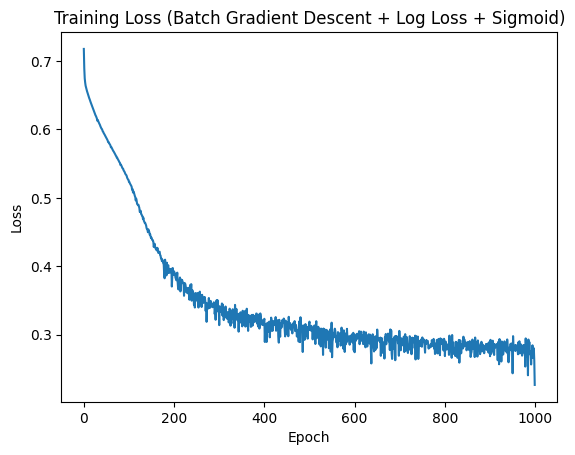

Độ chính xác trên tập test:
0.9
Kết quả dự đoán theo đặc trưng [4, 9]:
1


In [36]:
from abc import abstractmethod
import matplotlib.pyplot as plt


class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        self.input_shape = None
        self.output_shape = None
        raise NotImplementedError

    @abstractmethod
    def input(self):
        return self.input

    @abstractmethod
    def output(self):
        return self.output

    @abstractmethod
    def input_shape(self):
        return self.input_shape

    @abstractmethod
    def output_shape(self):
        return self.output_shape

    @abstractmethod
    def forward_propagation(self, input):
        raise NotImplementedError

    @abstractmethod
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError


import numpy as np

class FCLayer(Layer):
    def __init__(self, input_shape, output_shape):
        """
        :param input_shape: (1, 3)
        :param output_shape: (1, 4)
        (1X3) (3x4) => (1, 4)
        (3, 1) (1, 4) => (3x4)
        """
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.weights = np.random.rand(input_shape[1], output_shape[1]) - 0.5
        self.bias = np.random.rand(1, output_shape[1]) - 0.5

    def forward_propagation(self, input):
        self.input = input
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        current_layer_err = np.dot(output_error, self.weights.T)
        dweight = np.dot(self.input.T, output_error)
        self.weights -= dweight * learning_rate
        self.bias -= learning_rate * output_error
        return current_layer_err


class ActivationLayer(Layer):
    def __init__(self, input_shape, output_shape, activation, activation_prime):
        """
        :param input_shape: đầu vào input mảng (1, 4)
        :param output_shape: mảng
        :param activation: hàm
        :param activation_prime: hàm
        """
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input):
        self.input = input
        self.output = self.activation(input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def setup_loss(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input):
        result = []
        n = len(input)
        for i in range(n):
            output = input[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result
    
    def accuracy(self, x_test, y_test):
        """
        Tính độ chính xác trên tập test.
        
        :param x_test: Dữ liệu đầu vào của tập test
        :param y_test: Nhãn của tập test
        :return: Độ chính xác trên tập test
        """
        predictions = self.predict(x_test)
        correct = 0
        total = len(y_test)
        for prediction, true_value in zip(predictions, y_test):
            if np.round(prediction) == true_value:
                correct += 1
        accuracy = correct / total
        return accuracy
    
    def fit(self, x_train, y_train, learning_rate, epochs, batch_size=1):
        n = len(x_train)
        losses = [] 
        for i in range(epochs):
            err = 0
            indices = np.arange(n)
            np.random.shuffle(indices)
            for j in range(0, n, batch_size):
                batch_indices = indices[j:min(j+batch_size, n)]
                batch_x = x_train[batch_indices]
                batch_y = y_train[batch_indices]
                batch_err = 0
                for k in range(len(batch_x)):
                    output = batch_x[k]
                    for layer in self.layers:
                        output = layer.forward_propagation(output)
                    batch_err += self.loss(batch_y[k], output)
                    error = self.loss_prime(batch_y[k], output)
                    for layer in reversed(self.layers):
                        error = layer.backward_propagation(error, learning_rate)
                err += batch_err / len(batch_x)
            err /= (n // batch_size)
            losses.append(err)
            print('epoch : %d/%d err = %f' % (i+1, epochs, err))
# Plot the loss
        losses = np.squeeze(losses)
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss (Batch Gradient Descent + Log Loss + Sigmoid)')
        plt.show()

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def log_loss(y_true, y_pred):
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def log_loss_prime(y_true, y_pred):
    return - (y_true / y_pred - (1 - y_true) / (1 - y_pred))

from sklearn.model_selection import train_test_split

df = pd.read_csv('data_logistic.csv')
data = df.to_numpy()
X = data[:, :-1]  
y = data[:, -1].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

x_train = np.reshape(X_train, (X_train.shape[0], 1, 2))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))

net = Network()
net.add(FCLayer((1, 2), (1, 3)))
net.add(ActivationLayer((1, 3), (1, 3), sigmoid, sigmoid_prime))
net.add(FCLayer((1, 3), (1, 1)))
net.add(ActivationLayer((1, 1), (1, 1), sigmoid, sigmoid_prime))
net.setup_loss(log_loss, log_loss_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.01)

print("Độ chính xác trên tập test:")
accuracy = net.accuracy(X_test, y_test)
print(accuracy)

print("Kết quả dự đoán theo đặc trưng [4, 9]:")
out = net.predict([[4, 9]])
print(1) if out[0][0][0] >= 0.5 else print(0)
